Definimos la función likelihood

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import scipy.stats as st
from scipy.optimize import minimize
import math
from multiprocessing import Pool
import emcee

os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
# Parámetros del modelo 
Omega_r0 = 0.0
Omega_m0 = 0.33
Omega_l0 = 0.66
h0 = 70 # km / s * Mpc
P = 600 #Número de valores de redshift

Leemos los datos a analizar

In [3]:
valores_z = np.loadtxt('Datos_Mock_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', delimiter = ',', usecols = 0)
distancias = np.loadtxt('Datos_Mock_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', delimiter = ',', usecols = 1)
errores = np.loadtxt('Datos_Mock_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', delimiter = ',', usecols = 2)

Definimos el modelo que usamos

In [4]:
def Omega_k(Omega_m0, Omega_l0, Omega_r0):
    Omega_k0 = 1 - Omega_m0 - Omega_l0 - Omega_r0
    return Omega_k0

def E(x, Omega_m0,  Omega_l0,  Omega_r0):
    return np.sqrt(Omega_m0*(1+x)**3  + Omega_k(Omega_m0, Omega_l0, Omega_r0)*(1+x)**2 + Omega_l0)

In [5]:
def IntFunct(x, Omega_m0, Omega_l0, Omega_r0):
    return E(x, Omega_m0, Omega_l0, Omega_r0)**(-1)

def integral(z, Omega_m0, Omega_l0, Omega_r0):
    return integrate.quad(IntFunct,0, z, args=(Omega_m0, Omega_l0, Omega_r0),epsabs=1.49e-4, epsrel=1.49e-03,full_output = 1)[0]

Función que calcula la distancia de luminosidad, 

$$ d_L=\frac{c(1+z)}{\sqrt{|\Omega_{k, 0}|}H_0}S_k\left(\sqrt{|\Omega_{k, 0}}|\int_0^z\frac{dz}{E(z)}  \right) $$ 

donde 

$$ S_k(x)= \begin{cases}
    \sin(x), \hspace{0.5cm} k>0\\
    x, \hspace{1.35cm} k = 0\\
    \sinh(x), \hspace{0.35cm} k <0
    \end{cases} $$

In [6]:
def distancia_luminosidad(z, h0, Omega_m0,  Omega_l0,  Omega_r0):
    
    c = 3 * 10**5 # km / s
    intl = integral(z, Omega_m0, Omega_l0, Omega_r0)
    
    if Omega_k(Omega_m0, Omega_l0, Omega_r0) < 0: # Abierto
        prefactor = c * (1 + z)/(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * h0)
        d_L = prefactor * np.sin(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * intl)
    elif Omega_k(Omega_m0, Omega_l0, Omega_r0) == 0: 
        d_L = c * (1 + z) * intl / h0
    else: # Cerrado
        prefactor = c * (1 + z)/(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * h0)
        d_L = prefactor * np.sinh(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * intl)
        
    return d_L

distancia_luminosidad_vec = np.vectorize(distancia_luminosidad)

Definimos la función likelihood

In [7]:
def log_likelihood(theta, z, distancia, yerr):
    h0, Omega_m0, Omega_l0 = theta # Parámetros a minimizar
    model = distancia_luminosidad_vec(z, h0, Omega_m0,  Omega_l0,  Omega_r0)
    sigma2 = np.array(yerr)**2
    return -0.5 * np.sum((distancia - model) ** 2 / sigma2)

Definimos el prior.

$$
p(H_0)=
\begin{cases}
1, \text{ if } 50<H_0<100\\
0, \text{ otherwise}
\end{cases}
$$
$$
p(\Omega_m)=
\begin{cases}
1, \text{ if } 0<\Omega_m<1\\
0, \text{ otherwise}
\end{cases}
$$
$$
p(\Omega_\lambda)=
\begin{cases}
1, \text{ if } 0<\Omega_\lambda<1\\
0, \text{ otherwise}
\end{cases}
$$
$$
p(\Omega_r)=
0
$$
$$
\Omega_k = 1 - \Omega_m - \Omega_\lambda - \Omega_r
$$

In [8]:
def log_prior(theta):
    h0, Omega_m0, Omega_l0 = theta # Parámetros a minimizar
    if 50< h0 < 100 and 0 < Omega_m0 < 1 and 0 < Omega_l0 < 1: # and and 0.0 < Omega_m0+Omega_l0+Omega_k(Omega_m0, Omega_l0, Omega_r0) <= 1.0
        return 0.0
    return -np.inf

def condition(theta, z):
    H, Omega_m0, Omega_l0 = theta
    
    z_max = np.max(z)
    result = Omega_m0*(1+z_max)**3  + Omega_k(Omega_m0, Omega_l0, Omega_r0)*(1+z_max)**2 + Omega_l0
    if result < 0:
        return -np.inf
    return result

Combinamos ahora el prior con la función likelihood para dar la fución de probabilidad (el posterior salvo una constante)

In [9]:
def log_probability(theta, valores_z, distancia, error):
    if not np.isfinite(log_prior(theta)):
        lp = -np.inf
        return lp
    if not np.isfinite(condition(theta, valores_z)):
        lp = -np.inf
        return lp
    lp = 0.0
    Likelihood = log_likelihood(theta, valores_z, distancia, error) +lp
    return Likelihood # Si el valor de lp es finito, contruimos la funcion probabilidad
    

In [10]:
max_n = 10000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

h0_random = np.random.uniform(50, 100, 32)
omega_m_random = np.random.uniform(0, 1, 32)
omega_lambda_random = np.random.uniform(0, 1, 32)
pos = []
pos = np.column_stack((h0_random, omega_m_random, omega_lambda_random)) # Escribe los 3 vectores como columnas
nwalkers, ndim = pos.shape  # nwalker y ndim toma el valor del número de filas y el número de columnas del vector "pos", respectivamente.



with Pool(processes=6) as pool:
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(valores_z, distancias, errores))
    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        # np.all() es una función de NumPy que devuelve True si todos los elementos en 
            # una matriz o expresión son evaluados como verdaderos, y False en caso contrario.
        # If the chain is longer than 100 times the estimated autocorrelation time and if 
            # this estimate changed by less than 1%, we’ll consider things converged.
        converged = np.all(sampler.iteration > 100 * tau)  
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01) 
        if converged:
            break
        old_tau = tau
        n = 100 * np.arange(1, index + 1)
        y = autocorr[:index]  
        plt.plot(n, n / 100.0, "--k", label = "Línea $\tau / 100$")
            # Pintamos la recta x = y / 100 porque una condición de convergencia es que 
            # la cadena sea 100 veces más larga que tau. De esta manera podremos
            # comprobarlo de manera más visual
        plt.plot(n, y, label = "$\tau$ calculada")
        plt.xlim(0, n.max())
        plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
        plt.xlabel("Número de elementos de la cadena")
        plt.ylabel(r"$\hat{\tau}$ medio")
        file_name_fig = 'autocorrelation.pdf'
        plt.savefig(file_name_fig)
        plt.close()

        
n = 100 * np.arange(1, index + 1)
y = autocorr[:index]  
plt.plot(n, n / 100.0, "--k", label = r"Línea $\hat{\tau} / 100$")
     # Pintamos la recta x = y / 100 porque una condición de convergencia es que 
     # la cadena sea 100 veces más larga que tau. De esta manera podremos
     # comprobarlo de manera más visual
plt.plot(n, y, label = r"$\hat{\tau}$ calculado")
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("Número de elementos de la cadena")
plt.ylabel(r"$\hat{\tau}$ medio")
plt.legend(loc = "lower right")
file_name_fig = 'autocorrelation.pdf'
plt.savefig(file_name_fig)
plt.close()
plt.show()


 36%|███▌      | 3600/10000 [2:09:42<3:50:35,  2.16s/it] 


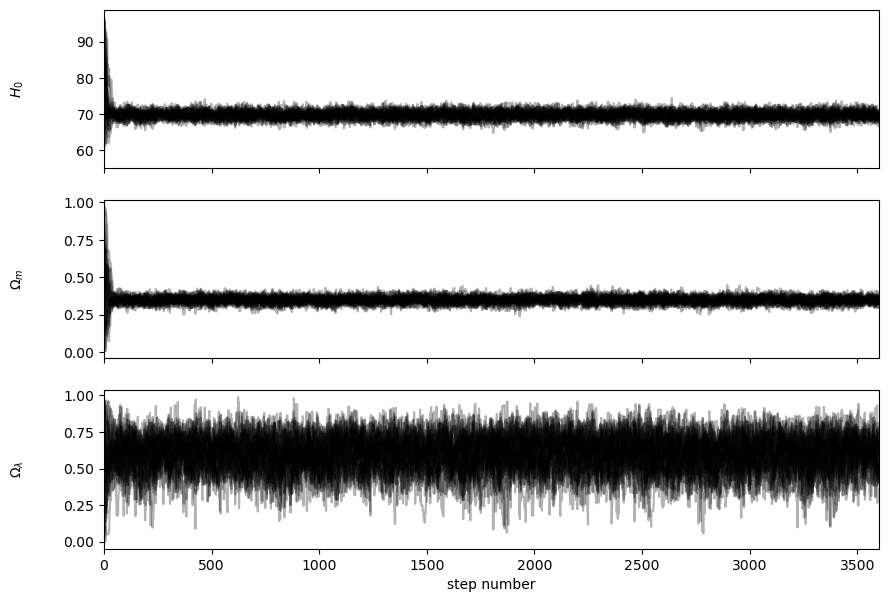

In [11]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$H_0$", "$\Omega_m$", "$\Omega_\lambda$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
file_name_fig = 'samples.pdf'
plt.savefig(file_name_fig)

In [12]:
tau = sampler.get_autocorr_time()  # autocorrelation
burnin = int(2 * np.max(tau))  # burn in phase
thin = int(0.5 * np.min(tau))  
print("burnin: ", burnin)
print("thin: ", thin)
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("tau: ", tau)
print("--------")
print("samples shape: ", samples.shape)
print("flat samples shape: ", flat_samples.shape)
np.savetxt('flat_samples_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', flat_samples, delimiter = ',')


burnin:  71
thin:  16
tau:  [32.04516583 35.8413383  35.46731034]
--------
samples shape:  (3600, 32, 3)
flat samples shape:  (7040, 3)


[[70.62457902  0.34285302  0.7150798 ]
 [70.20772665  0.32221078  0.59596932]
 [68.10125722  0.35185101  0.48940461]
 ...
 [70.06606152  0.3234129   0.61686953]
 [67.89689455  0.33883953  0.42778438]
 [71.45131832  0.32912398  0.75385201]]


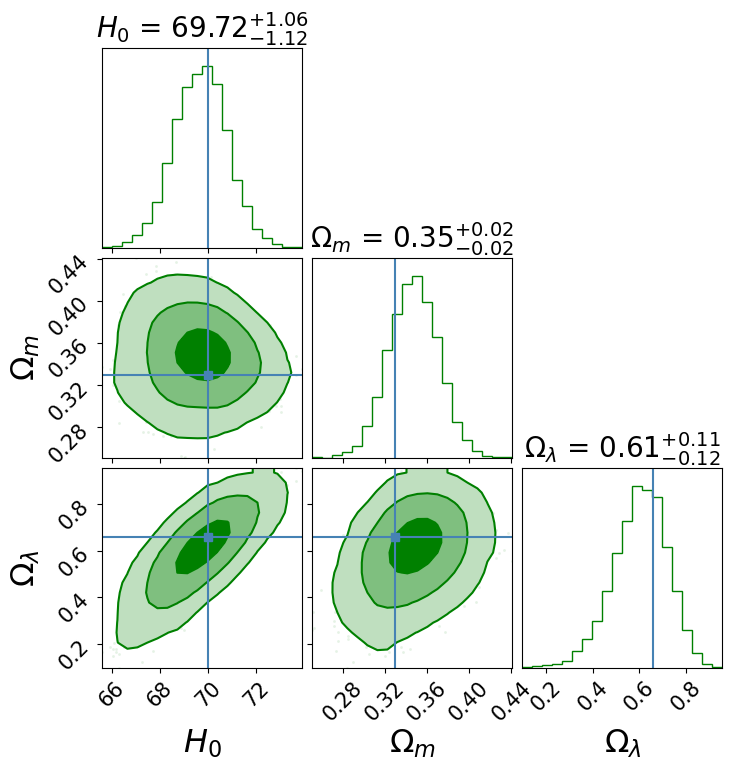

In [16]:
import corner
# Parámetros del modelo
labels = ["$H_0$", "$\Omega_m$", "$\Omega_\lambda$"]
flat_samples = np.genfromtxt('flat_samples_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', delimiter = ",")
print(flat_samples)
fig = corner.corner(flat_samples, labels=labels,fill_contours=True,bins=20, color='green', show_titles=True,smooth=1.0, 
                        label_kwargs={"fontsize": 23},title_kwargs={"fontsize": 20}, tick_kwargs={"fontsize": 30},
                        levels=(1-np.exp(-0.5),1-np.exp(-2.0),1-np.exp(-4.5)), truths =[h0, Omega_m0, Omega_l0])


fig.savefig('Datos_Mock_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.pdf')

In [17]:
sigma_h0 = np.std(flat_samples[:, 0])
print(sigma_h0)

sigma_Omega_m0 = np.std(flat_samples[:, 1])
print(sigma_Omega_m0)

sigma_Omega_l0 = np.std(flat_samples[:, 2])
print(sigma_Omega_l0)

1.1122527817290904
0.023444772255613804
0.11571537364805398


Sacamos los resultados con sus respectivos errores

In [15]:
from IPython.display import display, Math

results = []
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    print(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    append = [mcmc[1], q[0], q[1]]
    results.append(append)
    display(Math(txt))
np.savetxt('Resultados_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', results, delimiter=',')
    
    

[68.60308453 69.7249233  70.78956756]


<IPython.core.display.Math object>

[0.32421144 0.34773542 0.37104537]


<IPython.core.display.Math object>

[0.49049995 0.6112488  0.71824243]


<IPython.core.display.Math object>